In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

model_number = 3

In [3]:
IN_SHAPE, DELTA = 0, 0
if model_number == 1: 
    IN_SHAPE += 75
    DELTA = config["resolution"]
    seeing = config["seeing_1"]
elif model_number == 2: 
    IN_SHAPE += 64
    DELTA = config["resolution_2"]
    seeing = config["seeing_2"]
else: 
    IN_SHAPE += 64
    DELTA = config["resolution_3"]
    seeing = config["seeing_3"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]

alpha_t_scaling = config["alpha_t_scaling"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]]
alpha_signs = torch.tensor([-1 for _ in range(IN_SHAPE)]+[1 for __ in range(IN_SHAPE)])

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

In [4]:
dataset_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm'],5000)

HR_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub_HR'],5000)
HR_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion_HR'],5000)
HR_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm_HR'],5000)

In [5]:
alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = None
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, feature_extractor=None, sersic_args = [1, 1, 0.25])
alpha_model.load_state_dict(torch.load('Weights_%d.pt'%(model_number), weights_only=True))

<All keys matched successfully>

In [6]:
def give_image(dataset, HR_dataset, alpha_model, length, i=None, plot=False):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)

    if plot:
        plot, axes = plt.subplots(1,4)
        plot.set_size_inches(20,5)
        axes[0].imshow(Image.fromarray(sersic_profile.detach().cpu().numpy()[0]*255))
        axes[1].imshow(Image.fromarray(LR.detach().cpu().numpy()[0]*255))
        axes[2].imshow(Image.fromarray(source_profile.detach().cpu().numpy()[0]*255))
        axes[3].imshow(Image.fromarray(HR_dataset[i].detach().cpu().numpy()[0]*255))
        axes[0].set_title('Lensed')
        axes[1].set_title('LR')
        axes[2].set_title('Source')
        axes[3].set_title('HR')

    return sersic_profile[0].cpu(), LR, source_profile, HR_dataset[i][0].cpu()

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([[5.6391e-09, 7.0665e-09, 8.7536e-09,  ..., 7.9217e-10, 3.6085e-10,
          0.0000e+00],
         [7.2772e-09, 9.0386e-09, 1.1124e-08,  ..., 1.3278e-09, 8.0024e-10,
          3.6015e-10],
         [9.2691e-09, 1.1440e-08, 1.4013e-08,  ..., 1.9724e-09, 1.3279e-09,
          7.9323e-10],
         ...,
         [5.0144e-08, 6.1184e-08, 7.4457e-08,  ..., 1.4028e-08, 1.1132e-08,
          8.7595e-09],
         [4.1245e-08, 5.0308e-08, 6.1187e-08,  ..., 1.1449e-08, 9.0477e-09,
          7.0694e-09],
         [3.3829e-08, 4.1256e-08, 5.0158e-08,  ..., 9.2738e-09, 7.2853e-09,
          5.6424e-09]]),
 tensor([[[0.0025, 0.0021, 0.0021,  ..., 0.0022, 0.0018, 0.0026],
          [0.0008, 0.0026, 0.0028,  ..., 0.0021, 0.0016, 0.0014],
          [0.0016, 0.0022, 0.0014,  ..., 0.0010, 0.0026, 0.0026],
          ...,
          [0.0018, 0.0020, 0.0024,  ..., 0.0034, 0.0023, 0.0025],
          [0.0030, 0.0022, 0.0025,  ..., 0.0005, 0.0023, 0.0018],
          [0.0018, 0.0016, 0.0021,  ..., 0.00

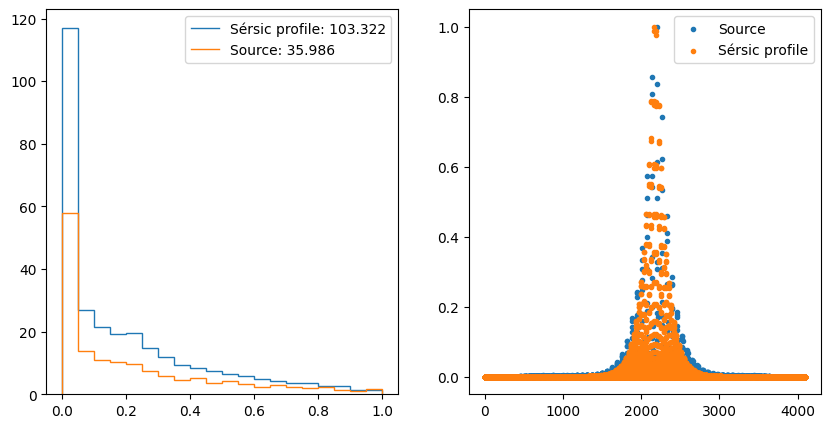

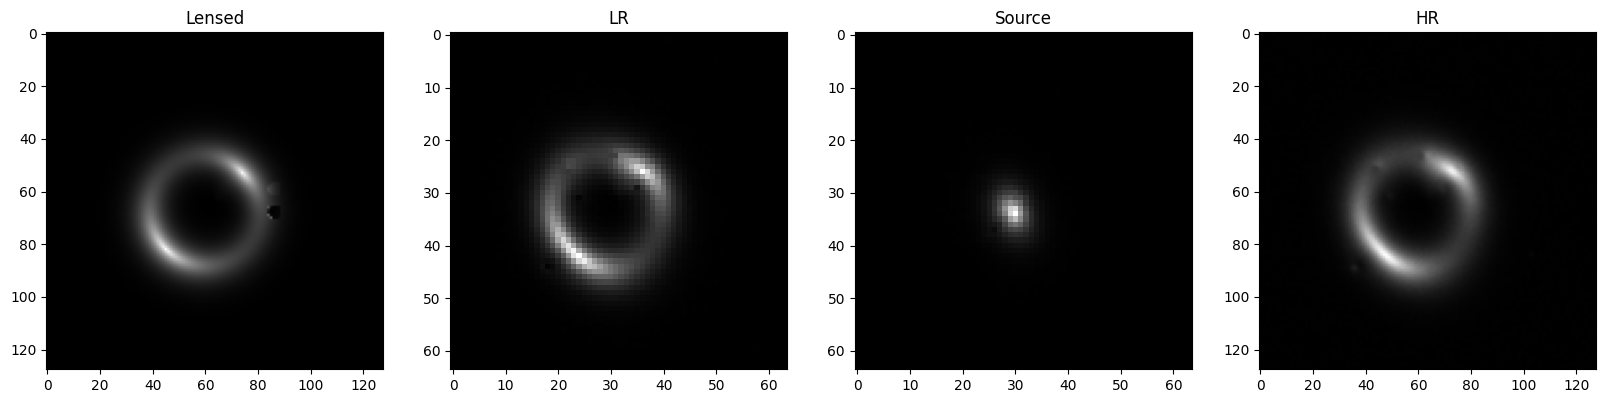

In [7]:
give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_cdm), plot=True)

In [8]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history_no_sub = {'loss':[],'SSIM':[], 'PSNR':[]}
history_axion = {'loss':[],'SSIM':[], 'PSNR':[]}
history_cdm = {'loss':[],'SSIM':[], 'PSNR':[]}

In [9]:
alpha_model.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    image, _, __, HR = give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_cdm['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_cdm['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_cdm['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    image, _, __, HR = give_image(dataset_no_sub, HR_no_sub, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_no_sub['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_no_sub['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_no_sub['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    image, _, __, HR = give_image(dataset_axion, HR_axion, alpha_model, len(dataset_no_sub), i)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_axion['loss'].append(float(loss))
    image, HR = image.numpy(), HR.numpy()
    history_axion['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_axion['PSNR'].append(PSNR(float(loss)))

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:32<00:00, 152.51it/s]


In [10]:
print(f"no_sub: Evaluation completed with \nMSE: {np.mean(history_no_sub['loss'])} ({np.std(history_no_sub['loss'])})\nSSIM: {np.mean(history_no_sub['SSIM'])} ({np.std(history_no_sub['SSIM'])})\nPSNR:  {np.mean(history_no_sub['PSNR'])} ({np.std(history_no_sub['PSNR'])})")
print(f"axion: Evaluation completed with \nMSE: {np.mean(history_axion['loss'])} ({np.std(history_axion['loss'])})\nSSIM: {np.mean(history_axion['SSIM'])} ({np.std(history_axion['SSIM'])})\nPSNR:  {np.mean(history_axion['PSNR'])} ({np.std(history_axion['PSNR'])})")
print(f"cdm: Evaluation completed with \nMSE: {np.mean(history_cdm['loss'])} ({np.std(history_cdm['loss'])})\nSSIM: {np.mean(history_cdm['SSIM'])} ({np.std(history_cdm['SSIM'])})\nPSNR:  {np.mean(history_cdm['PSNR'])} ({np.std(history_cdm['PSNR'])})")

no_sub: Evaluation completed with 
MSE: 0.0014252494265157853 (0.001004557580678865)
SSIM: 0.8187538384831496 (0.025124879611246046)
PSNR:  29.343366978238237 (2.7509287650906895)
axion: Evaluation completed with 
MSE: 0.002304002260811291 (0.001644643289318463)
SSIM: 0.7959038691082821 (0.031651321611953255)
PSNR:  27.31148361713744 (2.8331931604405014)
cdm: Evaluation completed with 
MSE: 0.0016818960034430564 (0.0011317376278767832)
SSIM: 0.8067404440310187 (0.027713964928660077)
PSNR:  28.549610169225822 (2.6208979214566956)


In [11]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Sub-structure","MSE","SSIM","PSNR"]
table.add_row(["No_substructure","%0.6f"%np.mean(history_no_sub['loss']),"%0.3f"%np.mean(history_no_sub['SSIM']),"%0.3f"%np.mean(history_no_sub['PSNR'])])
table.add_row(["Axion (vortex)","%0.6f"%np.mean(history_axion['loss']),"%0.3f"%np.mean(history_axion['SSIM']),"%0.3f"%np.mean(history_axion['PSNR'])])
table.add_row(["CDM (sub-halos)","%0.6f"%np.mean(history_cdm['loss']),"%0.3f"%np.mean(history_cdm['SSIM']),"%0.3f"%np.mean(history_cdm['PSNR'])])
print(table)

+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.001425 | 0.819 | 29.343 |
|  Axion (vortex) | 0.002304 | 0.796 | 27.311 |
| CDM (sub-halos) | 0.001682 | 0.807 | 28.550 |
+-----------------+----------+-------+--------+


In [12]:
"""
Model 1: (finetune)
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003310 | 0.718 | 25.255 |
|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |
| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.002907 | 0.223 | 25.603 |
|  Axion (vortex) | 0.002890 | 0.221 | 25.663 |
| CDM (sub-halos) | 0.002998 | 0.220 | 25.484 |
+-----------------+----------+-------+--------+

Model 3:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003158 | 0.787 | 26.728 |
|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |
| CDM (sub-halos) | 0.003133 | 0.779 | 26.486 |
+-----------------+----------+-------+--------+
"""

'\nModel 1: (finetune)\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003310 | 0.718 | 25.255 |\n|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |\n| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.002907 | 0.223 | 25.603 |\n|  Axion (vortex) | 0.002890 | 0.221 | 25.663 |\n| CDM (sub-halos) | 0.002998 | 0.220 | 25.484 |\n+-----------------+----------+-------+--------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003158 | 0.787 | 26.728 |\n|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |\n| CDM (sub-halos) | 0

In [13]:
""" FeatureGAN: 
Model 1:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.004442 | 0.745 | 24.305 |
|  Axion (vortex) | 0.002908 | 0.770 | 25.902 |
| CDM (sub-halos) | 0.003376 | 0.756 | 25.310 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003510 | 0.213 | 25.108 |
|  Axion (vortex) | 0.003573 | 0.212 | 24.882 |
| CDM (sub-halos) | 0.003649 | 0.210 | 24.942 |
+-----------------+----------+-------+--------+

Model 3:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.001425 | 0.819 | 29.343 |
|  Axion (vortex) | 0.002304 | 0.796 | 27.311 |
| CDM (sub-halos) | 0.001682 | 0.807 | 28.550 |
+-----------------+----------+-------+--------+
"""

' FeatureGAN: \nModel 1:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.004442 | 0.745 | 24.305 |\n|  Axion (vortex) | 0.002908 | 0.770 | 25.902 |\n| CDM (sub-halos) | 0.003376 | 0.756 | 25.310 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003510 | 0.213 | 25.108 |\n|  Axion (vortex) | 0.003573 | 0.212 | 24.882 |\n| CDM (sub-halos) | 0.003649 | 0.210 | 24.942 |\n+-----------------+----------+-------+--------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.001479 | 0.821 | 29.163 |\n|  Axion (vortex) | 0.001609 | 0.812 | 28.818 |\n| CDM (sub-halos) |